# Чтение и предобработка данных ионосферного зондирования

## Импорт библиотек

In [13]:
import numpy as np
#from parse import parse
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt


In [14]:
# Функция для преобразования строки даты и времени в np.datetime64
def parse_datetime(date_str, time_str):
    dt_str = f"{date_str.decode('utf-8')} {time_str.decode('utf-8')}"
    return np.datetime64(datetime.strptime(dt_str, '%Y.%m.%d %H:%M:%S'))

In [15]:
# Чтение данных из файла
def load_file(filename):
    data = np.loadtxt(filename, usecols=(3, 5, 7), 
                 encoding="cp1251",
                 dtype={'names': ('date', 'time', 'freq'),
                     'formats': ('S10', 'S10', 'f')},
                )
    # Объединение даты и времени в np.datetime64
    datetime_array = np.array([parse_datetime(row['date'], row['time']) for row in data])
    
    # Создаем DataFrame
    df = pd.DataFrame({
        'datetime': datetime_array,
        'freq': data['freq']
    })
    return df

In [16]:
# Загружаем данные из нескольких файлов
file_names = ["M20231015.txt", "M20231012.txt", "M20231011.txt"]
dataframes = [load_file(fname) for fname in file_names]

# Объединяем все DataFrame по столбцу 'datetime'
merged_df = pd.concat(dataframes, ignore_index=True)

merged_df['month_year_time'] = merged_df['datetime'].dt.floor('5min').dt.strftime('%Y-%m %H:%M')
merged_df['day'] = merged_df['datetime'].dt.strftime('%d')


In [22]:
# Группируем с точностью до 5 минут и вычисляем статистику
# Год-месяц и время с точностью до 5 минут
result_df_u = merged_df.groupby(pd.Grouper(key='month_year_time')).agg(
    count=('freq', 'size'),  # Количество измерений
    mean_freq=('freq', 'mean'),  # Среднее значение
    std_freq=('freq', 'std')  # Стандартное отклонение
).reset_index()


result_df_u['time'] = pd.to_datetime(result_df_u['month_year_time'], format='%Y-%m %H:%M')
result_df_u['utime'] = pd.to_datetime(result_df_u['month_year_time'], format='%Y-%m %H:%M').dt.time

result_df = result_df_u.sort_values(by=['time'])


# Выводим результат
print(result_df)

    month_year_time  count  mean_freq  std_freq                time     utime
0     2023-10 00:00      2  10.136400  0.030406 2023-10-01 00:00:00  00:00:00
1     2023-10 00:05      2  10.081850  0.107551 2023-10-01 00:05:00  00:05:00
2     2023-10 00:10      2  10.024855  0.188154 2023-10-01 00:10:00  00:10:00
3     2023-10 00:15      2   9.492690  0.080639 2023-10-01 00:15:00  00:15:00
4     2023-10 00:20      2   9.758750  0.779444 2023-10-01 00:20:00  00:20:00
..              ...    ...        ...       ...                 ...       ...
277   2023-10 23:35      3  10.829433  0.498645 2023-10-01 23:35:00  23:35:00
278   2023-10 23:40      3  10.698533  0.498075 2023-10-01 23:40:00  23:40:00
279   2023-10 23:45      3  10.060746  0.095101 2023-10-01 23:45:00  23:45:00
280   2023-10 23:50      3   9.917171  0.413130 2023-10-01 23:50:00  23:50:00
281   2023-10 23:55      3  14.263167  6.228398 2023-10-01 23:55:00  23:55:00

[288 rows x 6 columns]


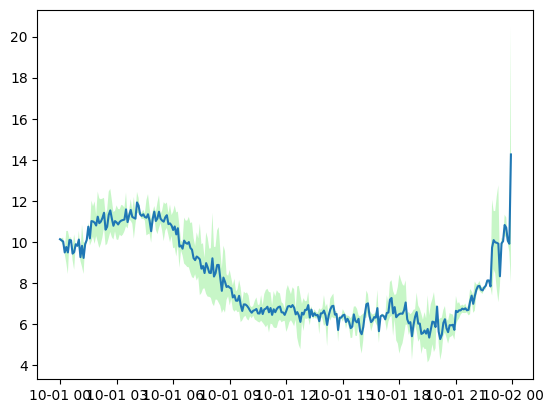

In [ ]:
plt.plot(result_df['time'], result_df['mean_freq'])
plt.fill_between(result_df['time'], 
                 result_df['mean_freq']-result_df['std_freq'], 
                 result_df['mean_freq']+result_df['std_freq'], 
                 facecolor='lightgreen', 
                 alpha=0.5,
                 label='1 sigma range',
                )
plt.show()

In [45]:
xls_cols = ['month_year_time', 'count', 'mean_freq', 'std_freq']
sheet_name = 'Sheet1'


with pd.ExcelWriter("out.xlsx", engine="xlsxwriter") as writer:
    result_df[xls_cols].to_excel(writer, sheet_name=sheet_name)
    workbook = writer.book
    worksheet = writer.sheets[sheet_name]
    chart = workbook.add_chart({"type": "line"})
    max_row = len(result_df)
    col = 3
    chart.add_series({
        'name':       [sheet_name, 0, col],
        'categories': [sheet_name, 1, 1, max_row, 1],
        'values':     [sheet_name, 1, col, max_row, col],
        'marker':     {'type': 'circle', 'size': 3},
        'y_error_bars': {'type': 'custom',
                         'plus_values': [sheet_name, 1, 4, max_row, 4],
                         'minus_values':[sheet_name, 1, 4, max_row, 4],
                        },
    })
    worksheet.insert_chart('G2', chart)

#xls_writer.close()